# Samuel Chiang USCID: 7187956023

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import impute
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## 1. The LASSO and Boosting for Regression

### (a) Download the Communities and Crime data1 from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

In [2]:
cols = []
fh = open('data/communities.names', 'r')
for f in fh:
    if f.startswith('@attribute'):
        cols.append(f.split()[1])
csv=pd.read_csv('data/communities.data', names = cols)
train = csv[0:1495]
test = csv[1495:]
test.reset_index(drop=True,inplace=True)
train.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


### (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [3]:
# first five are not predictive, need to impute test and train data separately
train = train.iloc[:,5:]
train = train.replace("?", np.nan)
imputer = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
train = pd.DataFrame(imputer.fit_transform(train), columns=train.columns)

test = test.iloc[:,5:]
test = test.replace("?", np.nan)
test = pd.DataFrame(imputer.transform(test), columns=test.columns)
df=pd.concat([train, test])
test.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,0.01,0.23,0.73,0.163975,0.080502,0.713054,0.451883,0.0,0.190753,0.12
1,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.01,0.18,0.02,0.163975,0.080502,0.713054,0.451883,0.0,0.190753,0.11
2,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,0.01,0.18,0.00,0.163975,0.080502,0.713054,0.451883,0.0,0.190753,0.12
3,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,0.06,0.13,0.16,0.163975,0.080502,0.713054,0.451883,0.0,0.190753,0.06
4,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,...,0.03,0.23,0.06,0.163975,0.080502,0.713054,0.451883,0.0,0.190753,0.12


### (c) Plot a correlation matrix for the features in the data set.

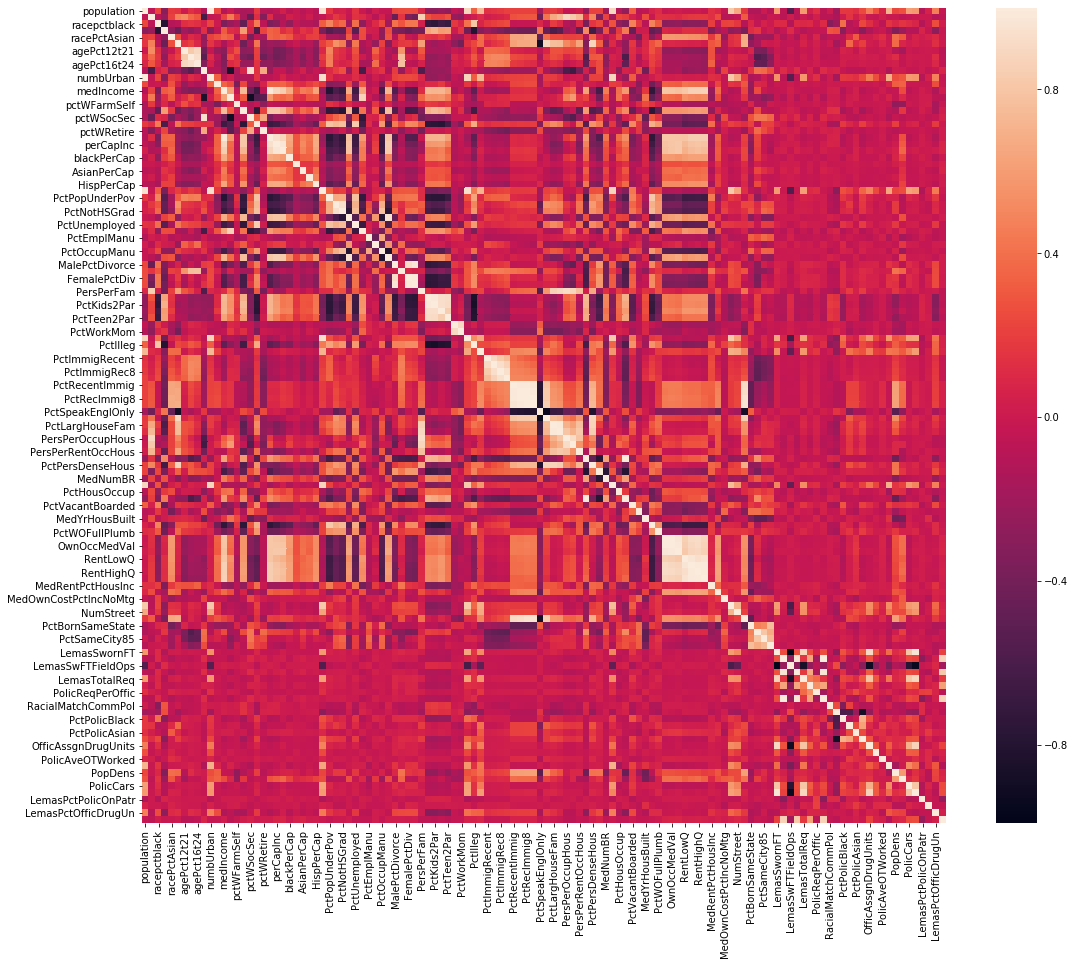

In [4]:
corr_matrix = df.corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix)

### (d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m , in which s is sample standard deviation and m is sample mean.

In [5]:
mean_df = df.mean(axis=0).to_frame()
mean_df.columns = ['mean']
std_df = df.std(axis=0).to_frame()
std_df.columns = ['std']
coefficient_df = pd.concat([std_df, mean_df], axis=1)
coefficient_df['Coefficient of Variation'] = coefficient_df['std'] / coefficient_df['mean'] 
coefficient_df

,std,mean,Coefficient of Variation
population,0.126906,0.057593,2.203503
householdsize,0.163717,0.463395,0.353298
racepctblack,0.253442,0.179629,1.410920
racePctWhite,0.244039,0.753716,0.323782
racePctAsian,0.208877,0.153681,1.359162
racePctHisp,0.232492,0.144022,1.614278
agePct12t21,0.155196,0.424218,0.365840
agePct12t29,0.143564,0.493867,0.290693
agePct16t24,0.166505,0.336264,0.495161
agePct65up,0.179185,0.423164,0.423442


### (e) Pick √128 features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [6]:
sorted_df = coefficient_df.sort_values(by=['Coefficient of Variation'], ascending=False)
top_cv = sorted_df.iloc[:int(np.floor(np.sqrt(128))),:].index
top_cv_df = df.loc[:, top_cv]
print(top_cv)
top_cv_df.head()

Index(['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig',
       'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban',
       'HousVacant', 'LandArea', 'racePctHisp'],
      dtype='object')


,NumStreet,NumInShelters,NumIlleg,NumImmig,LemasPctOfficDrugUn,NumUnderPov,population,numbUrban,HousVacant,LandArea,racePctHisp
0,0.0,0.04,0.04,0.03,0.32,0.08,0.19,0.20,0.21,0.12,0.17
1,0.0,0.00,0.00,0.01,0.00,0.01,0.00,0.02,0.02,0.02,0.07
2,0.0,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.04
3,0.0,0.00,0.03,0.02,0.00,0.01,0.04,0.06,0.01,0.02,0.10
4,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.01,0.04,0.05


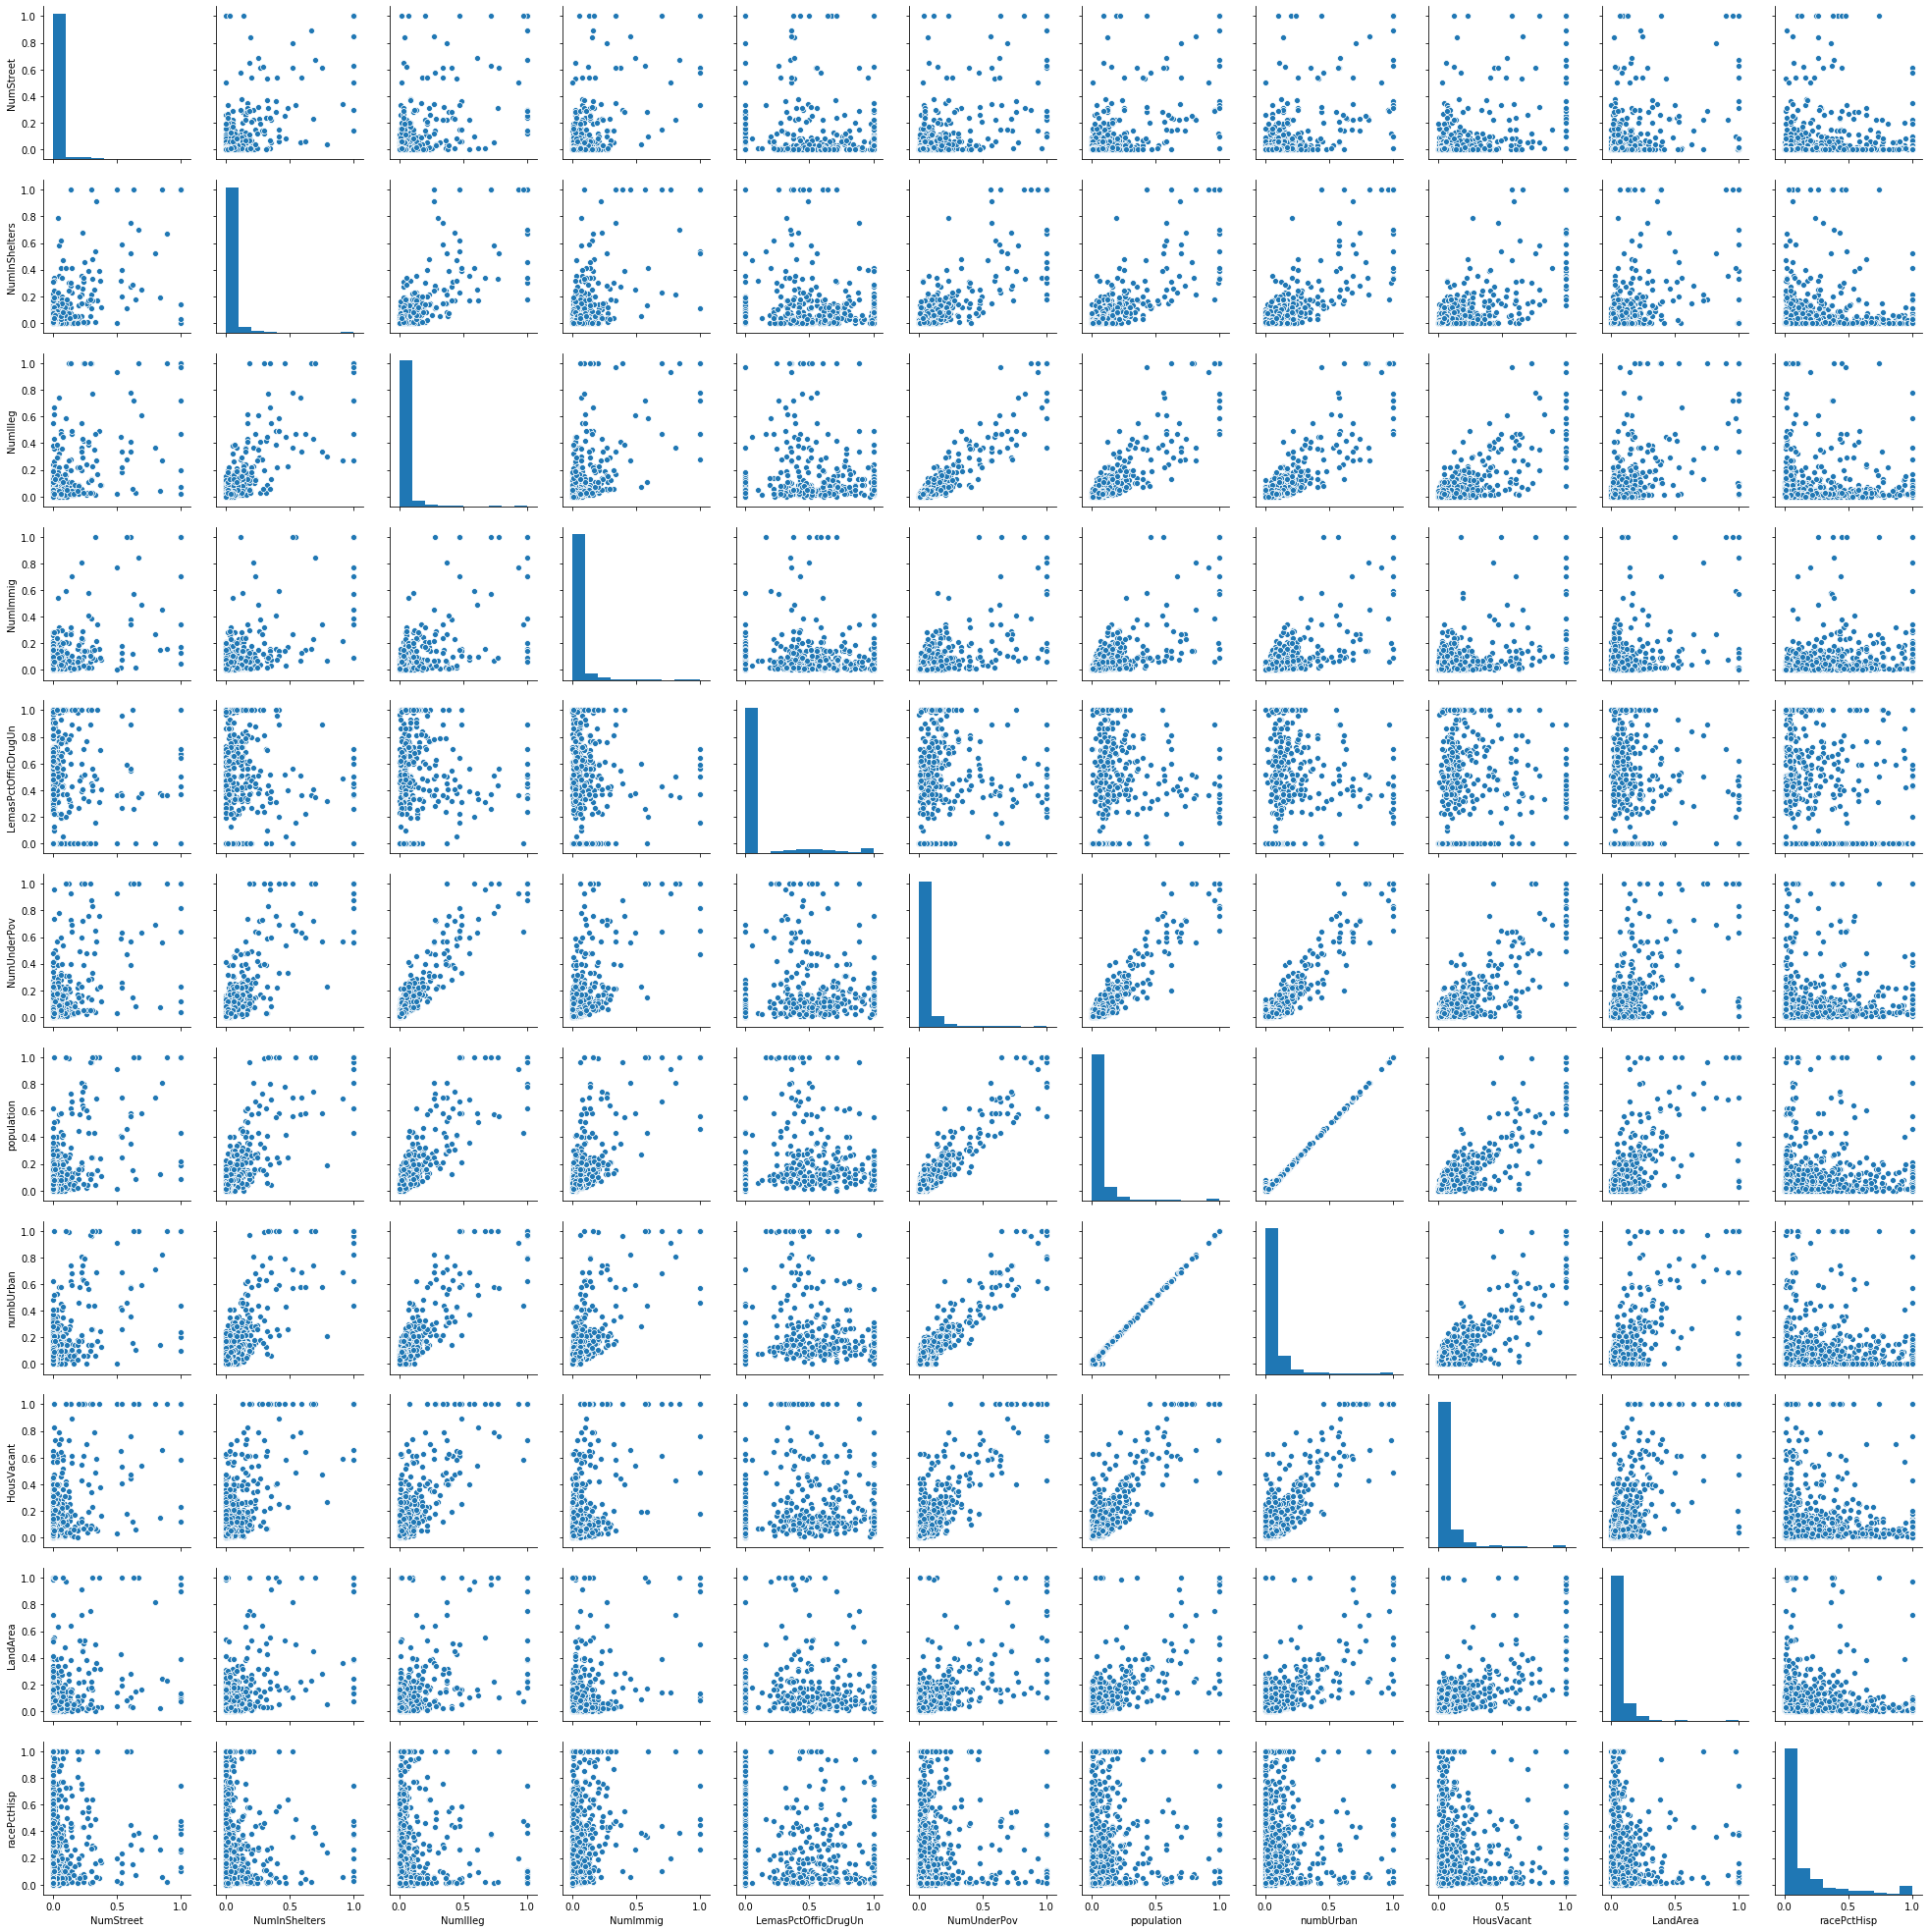

In [7]:
sns.pairplot(top_cv_df)

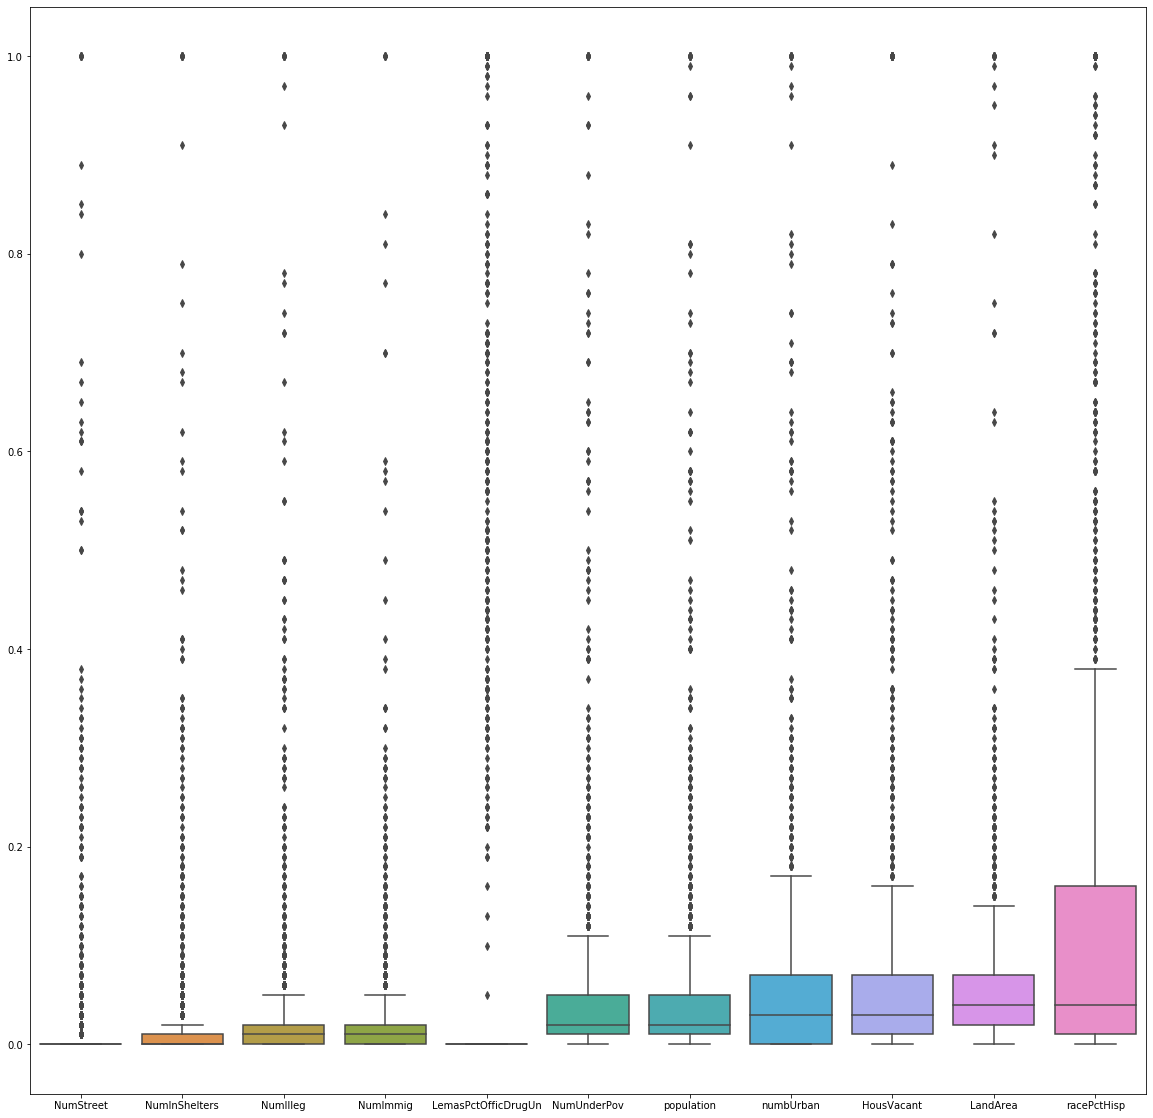

In [8]:
plt.figure(figsize=(20,20))
sns.boxplot(data=top_cv_df)

<p> Based on the scatterplot of all the high cv features, there is clearly a strong correlation between the three values of  'PctRecImmig5', 'PctRecentImmig', and 'PctRecImmig8'. This could increase the standard errors of their coefficients, and make these coefficients potentially unstable. There is also a slight correlation between 'PctNotSpeakEnglWell' and all three values of 'PctRecImmig5', 'PctRecentImmig', and 'PctRecImmig8' that can be observed as well. </p>

### (f) Fit a linear model using least squares to the training set and report the test error.

In [9]:
x_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
x_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

lr = LinearRegression().fit(x_train, y_train)
train_error = metrics.mean_squared_error(y_train, lr.predict(x_train))
test_error = metrics.mean_squared_error(y_test, lr.predict(x_test))
print('The Train Error for our Linear Regression Model is:', train_error)
print('The Test Error for our Linear Regression Model is:', test_error)

The Train Error for our Linear Regression Model is: 0.016309485245879014
The Test Error for our Linear Regression Model is: 0.018141971135530083


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:503: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


### (g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [10]:
rrcv = RidgeCV(cv = 5)
rrcv = rrcv.fit(x_train, y_train)
train_error = metrics.mean_squared_error(y_train, rrcv.predict(x_train))
test_error = metrics.mean_squared_error(y_test, rrcv.predict(x_test))
print("The Train Error for our Ridge Regression Model is: ", train_error)
print("The Test Error for our Ridge Regression Model is: ", test_error)
print("Alpha chosen: ", rrcv.alpha_)

The Train Error for our Ridge Regression Model is:  0.016694064866342524
The Test Error for our Ridge Regression Model is:  0.01773247499289665
Alpha chosen:  1.0


### (h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

### Non Standardized Lasso

In [11]:
# Non standardized
lcv = LassoCV(cv=5, normalize=False, max_iter=50000) 
lcv.fit(x_train, y_train)
train_error = metrics.mean_squared_error(y_train, lcv.predict(x_train))
test_error = metrics.mean_squared_error(y_test, lcv.predict(x_test))
print("The Train Error for our Lasso is: ", train_error)
print("The Test Error for our Lasso Model is: ", test_error)
print("Alpha chosen: ", lcv.alpha_)
lassoselect = pd.Series(data = lcv.coef_[lcv.coef_!=0], index = x_train.columns[lcv.coef_!=0] )
print('Number of features selected: ',len(lassoselect))
print('Features selected: ')
print(lassoselect)

The Train Error for our Lasso is:  0.01697699489601418
The Test Error for our Lasso Model is:  0.017758209216319674
Alpha chosen:  0.00011614723626829846
Number of features selected:  75
Features selected: 
racepctblack             0.271984
racePctAsian            -0.015671
agePct12t21              0.066658
agePct12t29             -0.265373
pctUrban                 0.040512
pctWWage                -0.084811
pctWFarmSelf             0.026607
pctWInvInc              -0.098512
pctWSocSec               0.048560
pctWPubAsst              0.038868
pctWRetire              -0.108431
whitePerCap             -0.058019
blackPerCap             -0.021056
indianPerCap            -0.031131
AsianPerCap              0.029002
OtherPerCap              0.022693
HispPerCap               0.023950
PctPopUnderPov          -0.141188
PctLess9thGrade         -0.018354
PctEmploy                0.137394
PctEmplManu             -0.015673
PctOccupManu             0.010102
MalePctDivorce           0.118069
MalePctNevM

### Standardized Lasso

In [12]:
scaler = preprocessing.StandardScaler()
standard_x_train = scaler.fit_transform(x_train)
standard_x_test = scaler.fit_transform(x_test)
standard_x_train = pd.DataFrame(standard_x_train, columns=x_train.columns)
standard_x_test = pd.DataFrame(standard_x_test, columns=x_test.columns)

lcv = LassoCV(cv=5, normalize=False, max_iter=50000) 
lcv.fit(standard_x_train, y_train)
train_error = metrics.mean_squared_error(y_train, lcv.predict(standard_x_train))
test_error = metrics.mean_squared_error(y_test, lcv.predict(standard_x_test))
print("The Train Error for our Lasso Model is: ", train_error)
print("The Test Error for our Lasso Model is: ", test_error)
print("Alpha chosen: ", lcv.alpha_)
lassoselect = pd.Series(data = lcv.coef_[lcv.coef_!=0], index = standard_x_train.columns[lcv.coef_!=0] )
print('Number of features selected: ',len(lassoselect))
print('Features selected: ')
print(lassoselect)

The Train Error for our Lasso Model is:  0.01704374974071744
The Test Error for our Lasso Model is:  0.017992169830321394
Alpha chosen:  0.0007630833878262516
Number of features selected:  73
Features selected: 
racepctblack             0.068248
racePctAsian            -0.000907
agePct12t21              0.010367
agePct12t29             -0.038253
pctUrban                 0.016588
pctWWage                -0.012059
pctWFarmSelf             0.004100
pctWInvInc              -0.020836
pctWSocSec               0.008884
pctWPubAsst              0.006135
pctWRetire              -0.017181
whitePerCap             -0.008624
blackPerCap             -0.003639
indianPerCap            -0.005237
AsianPerCap              0.005306
OtherPerCap              0.003816
HispPerCap               0.003992
PctPopUnderPov          -0.026742
PctLess9thGrade         -0.002048
PctEmploy                0.021190
PctEmplManu             -0.001042
MalePctDivorce           0.018976
MalePctNevMarr           0.020714
Female

<p> The test error with standardized features was only a bit higher than the test error without standardization. With standaridized features, the test error rate was 0.017992, while the non standardized data set gave a 0.017758 error rate. Although the difference isn't particularly worth noting, a potential reason that standardization did not significantly impact the error rate could be because the data was already normalized. </p>

### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [13]:
test_scores = []

length = list(range(1, x_train.shape[1] + 1))
for i in length:
    pca = PCA(n_components = i)
    principalComponents = pca.fit_transform(x_train)
    lr = LinearRegression()
    score = model_selection.cross_validate(lr, principalComponents, y_train.values.ravel(), cv=5,\
                                          scoring = 'neg_mean_squared_error')
    test_scores.append((score['test_score'] * -1).mean())
    
index = test_scores.index(min(test_scores))
M = length[index]
print('The best M is %d with cross validation score of %f.' %(M, min(test_scores)))

The best M is 96 with cross validation score of 0.019415.


In [114]:
lr = LinearRegression()
lr.fit(x_train.iloc[:,:M], y_train)
y_train_pred = lr.predict(x_train.iloc[:,:M])
y_test_pred = lr.predict(x_test.iloc[:,:M])
train_error = metrics.mean_squared_error(y_train, y_train_pred)
test_error = metrics.mean_squared_error(y_test, y_test_pred)
print("The Train Error for our PCR Model is: ", train_error)
print("The Test Error for our PCR Model is: ", test_error)

The Train Error for our PCR Model is:  0.016683818462472414
The Test Error for our PCR Model is:  0.017683626316658946


### (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation.

## 2. Tree-Based Methods

### (a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/ APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [98]:
aps_train = pd.read_csv('data/aps_failure_training_set.csv', header=14)
aps_test = pd.read_csv('data/aps_failure_test_set.csv', header=14)

### (b) Data Preparation <br> This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea.

### i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

* **Mean Imputation:** Use the mean value of the responses from the data to fill in the missing value. Not always recommended because it can artificially reduce the variability of your data but in some cases makes sense.
* **Common-Point Imputation:** For a rating scale, using the middle point or most commonly chosen value. For example, on a five-point scale, substitute a 3, the midpoint, or a 4, the most common value (in many cases). 
* **Regression Imputation:** Fit a regression model to estimate a missing value. Regression imputation predicts the missing value from the other values.
* **Hot Deck Imputation:** Randomly choose a data point and use its values to fill the missing values.
* **Cold Deck Imputation:** Systematically choose a data point and use its values to fill the missing values.
* **Interpolation and Extrapolation:** An estimated value from other observations from the same individual.
<br>

###  Technique: Mean Imputation

In [99]:
# Need to impute test and train data separately
aps_train = aps_train.replace("na", np.nan)
train_keep = aps_train.iloc[:,:1]
aps_train = aps_train.iloc[:,1:]
imputer = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
aps_train = pd.DataFrame(imputer.fit_transform(aps_train), columns=aps_train.columns)
aps_train.insert(0, "class", train_keep, True)

aps_test = aps_test.replace("na", np.nan)
test_keep = aps_test.iloc[:,:1]
aps_test = aps_test.iloc[:,1:]
aps_test = pd.DataFrame(imputer.transform(aps_test), columns=aps_test.columns)
aps_test.insert(0, "class", test_keep, True)

#aps_df=pd.concat([aps_train, aps_test])

### ii. For each of the 170 features, calculate the coefficient of variation CV = s/m, where s is sample standard deviation and m is sample mean.

In [87]:
mean_df = aps_train.mean(axis=0).to_frame()
mean_df.columns = ['mean']
std_df = aps_train.std(axis=0).to_frame()
std_df.columns = ['std']
coefficient_df = pd.concat([std_df, mean_df], axis=1)
coefficient_df['Coefficient of Variation'] = coefficient_df['std'] / coefficient_df['mean'] 
coefficient_df

,std,mean,Coefficient of Variation
aa_000,1.454301e+05,5.933650e+04,2.450938
ab_000,1.660588e+00,7.131885e-01,2.328400
ac_000,7.724678e+08,3.560143e+08,2.169767
ad_000,3.504515e+07,1.906206e+05,183.847620
ae_000,1.581420e+02,6.819130e+00,23.190937
af_000,2.053753e+02,1.100682e+01,18.658921
ag_000,2.036363e+04,2.216364e+02,91.878565
ag_001,3.400875e+04,9.757223e+02,34.854950
ag_002,1.494791e+05,8.606015e+03,17.369143
ag_003,7.574598e+05,8.859128e+04,8.550049


### iii. Plot a correlation matrix for your features using pandas or any other tool.

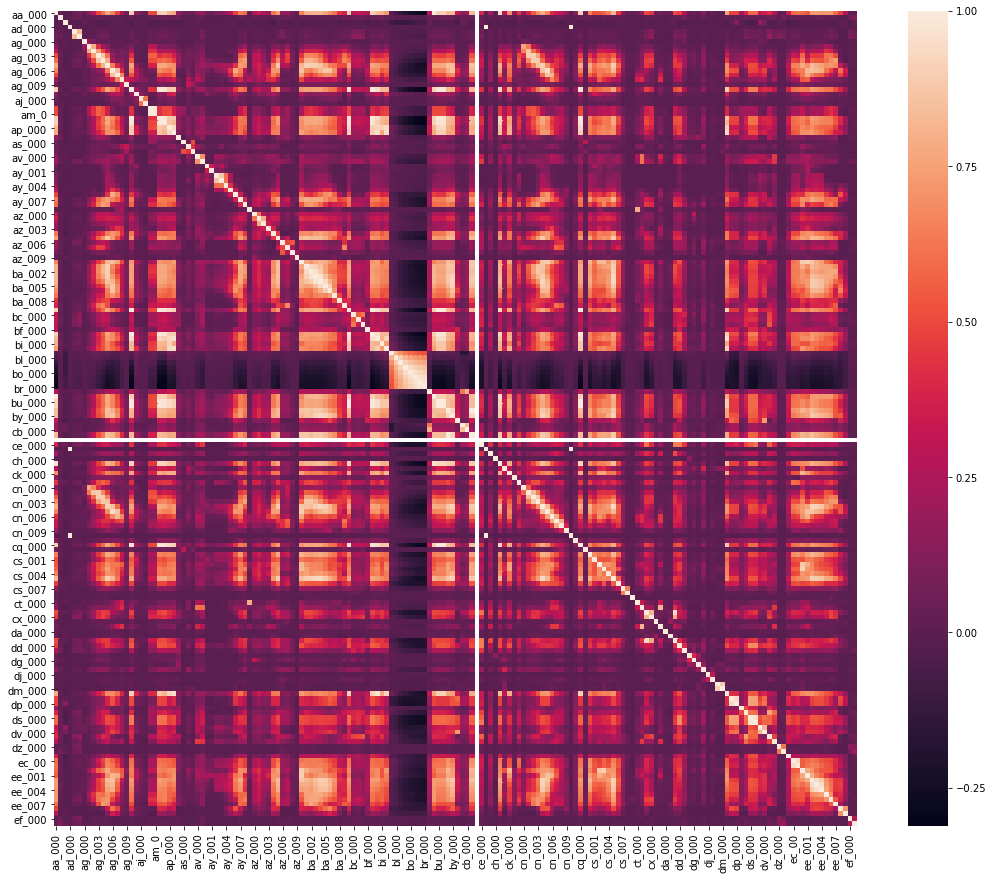

In [88]:
corr_matrix = aps_train.corr()
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix)

### iv. Pick ⌊ √170⌋ features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [89]:
sorted_df = coefficient_df.sort_values(by=['Coefficient of Variation'], ascending=False)
top_cv = sorted_df.iloc[:int(np.floor(np.sqrt(170))),:].index
top_cv_df = aps_train.loc[:, top_cv]
print(top_cv)
top_cv_df['class']=aps_train['class']
top_cv_df

Index(['cs_009', 'cf_000', 'co_000', 'ad_000', 'dh_000', 'dj_000', 'ag_000',
       'as_000', 'ay_009', 'az_009', 'ak_000', 'au_000', 'ch_000'],
      dtype='object')


,cs_009,cf_000,co_000,ad_000,dh_000,dj_000,ag_000,as_000,ay_009,az_009,ak_000,au_000,ch_000,class
0,0.0,2.000000,220.000000,280.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,neg
1,0.0,190221.810984,190515.566938,190620.639314,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000443,neg
2,0.0,0.000000,0.000000,100.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,neg
3,0.0,2.000000,2.000000,66.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,neg
4,0.0,0.000000,202.000000,458.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,neg
5,0.0,2.000000,2.000000,218.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,neg
6,0.0,190221.810984,190515.566938,190620.639314,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000443,neg
7,0.0,2.000000,6.000000,116.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,neg
8,0.0,190221.810984,190515.566938,190620.639314,0.000000,0.000000,0.0,0.0,0.0,2.0,0.000000,0.0,0.000443,neg
9,0.0,190221.810984,190515.566938,190620.639314,55760.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000443,pos


/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


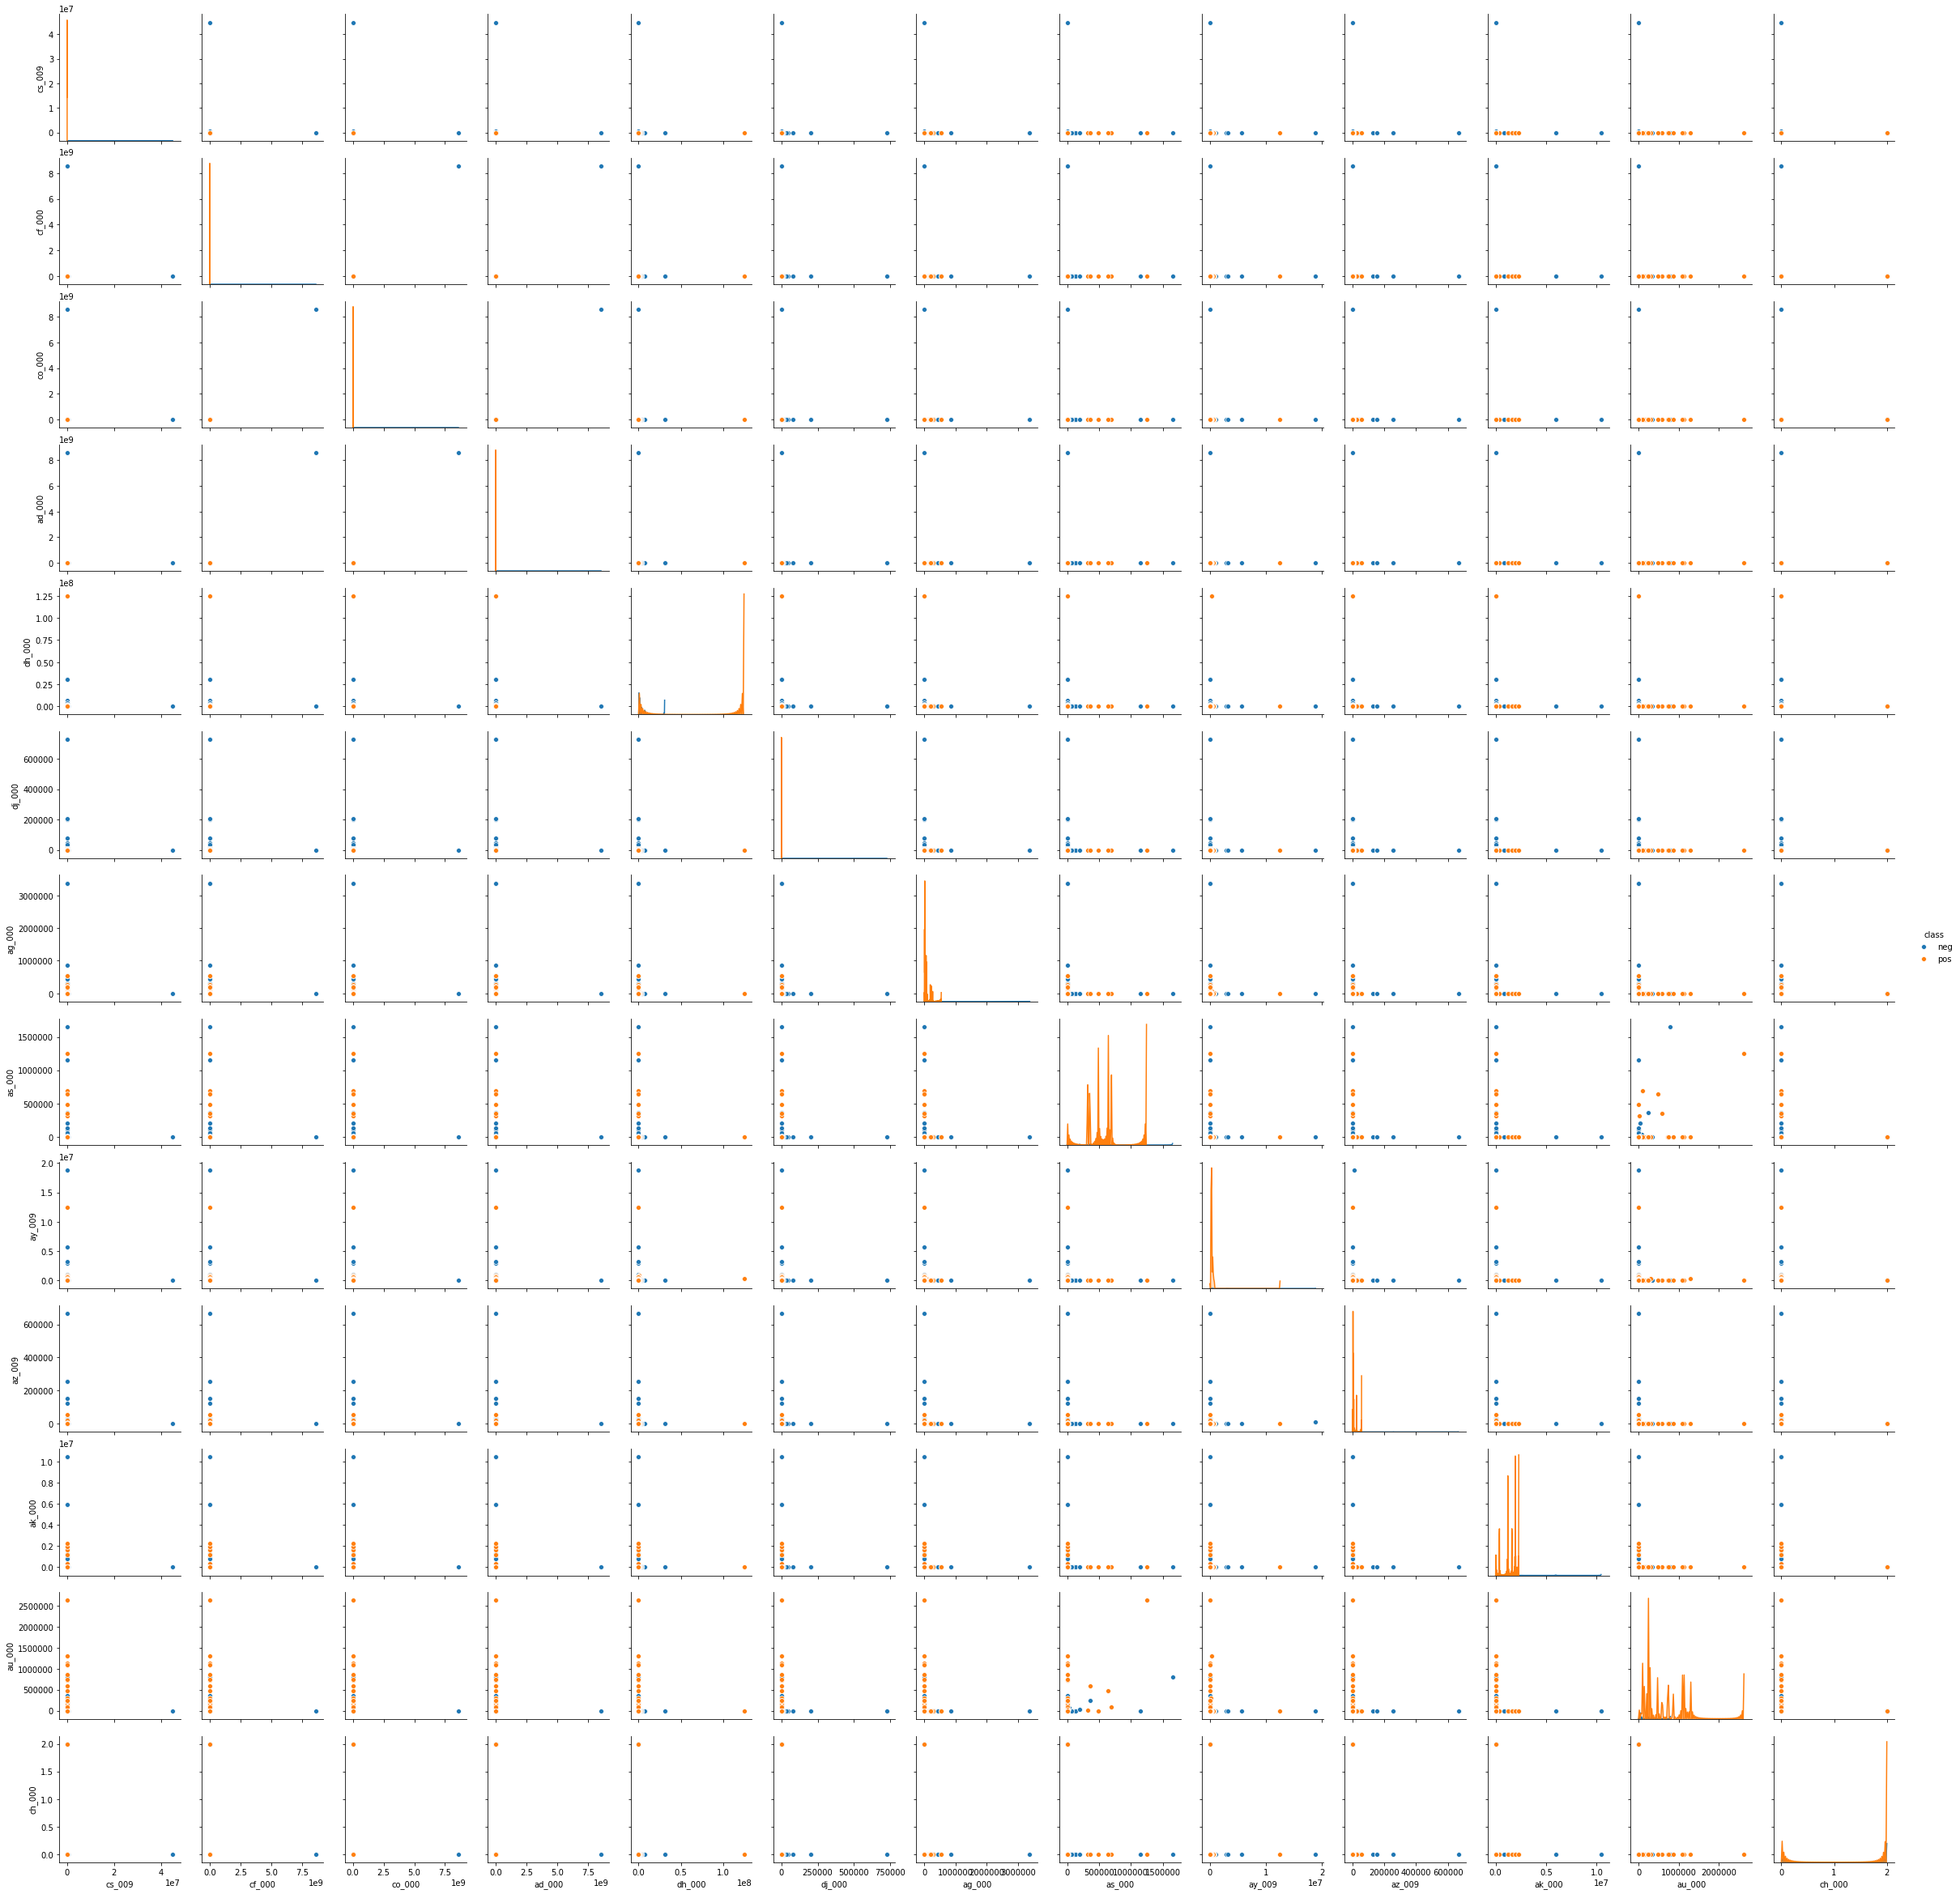

In [90]:
sns.pairplot(top_cv_df, hue="class")

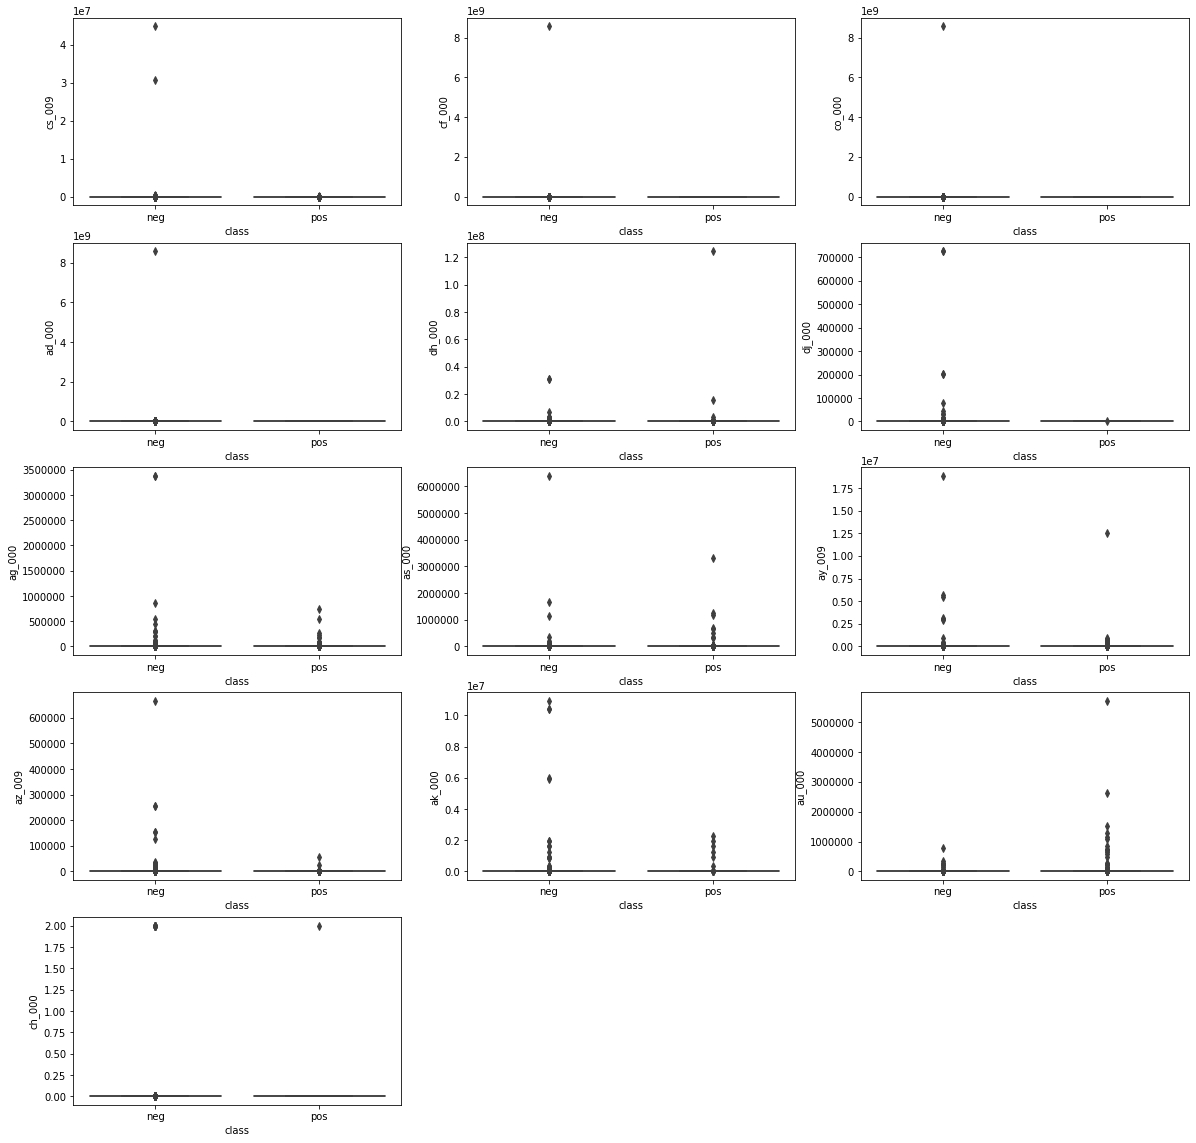

In [91]:
plt.figure(figsize=(20,20))
subplt = 1
for i in range(0,len(top_cv)):
    plt.subplot(5,3, subplt)
    sns.boxplot(x = 'class', y = top_cv[i], data=aps_df)
    subplt += 1

### v. Determine the number of positive and negative data. Is this data set imbalanced?

In [92]:
neg_count = aps_train[aps_train['class'] == 'neg'].shape[0]
pos_count = aps_train[aps_train['class'] == 'pos'].shape[0]

print('Negative data points:',neg_count)
print('Positive data points:',pos_count)

Negative data points: 59000
Positive data points: 1000


### (c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

The confusion matrix for the train data is: 
[[59000     0]
 [    0  1000]]


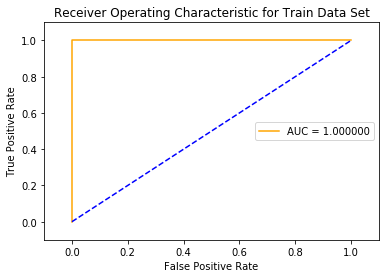

The train set error rate for Random Forest is:  0.0


In [100]:
aps_train['class'] = aps_train['class'].apply(lambda x: 1 if x == 'pos' else 0)
aps_test['class'] = aps_test['class'].apply(lambda x: 1 if x == 'pos' else 0)

x_train = aps_train.iloc[:,1:]
y_train = aps_train.iloc[:,0]
x_test = aps_test.iloc[:,1:]
y_test = aps_test.iloc[:,0]

rfc = RandomForestClassifier(n_estimators=100, random_state=0, oob_score=True)  
rfc.fit(x_train, y_train) 
y_train_pred = rfc.predict(x_train)
y_test_pred = rfc.predict(x_test)

# Train Data
# Confusion Matrix
print('The confusion matrix for the train data is: ')         
print(confusion_matrix(y_train, y_train_pred))

#Roc curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='orange', label='AUC = %f' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue',  linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('Receiver Operating Characteristic for Train Data Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="right")
plt.show()

#train error
train_error = 1 - accuracy_score(y_train, y_train_pred)
print('The train set error rate for Random Forest is: ', train_error)

The confusion matrix for the test data is: 
[[15606    19]
 [  108   267]]


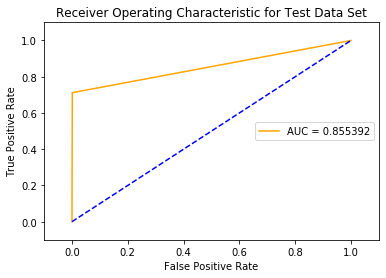

The Out of Bag error for Random Forest is: 0.006033333333333335
The test set error rate for Random Forest is:  0.007937500000000042


In [106]:
# Test Data
# Confusion Matrix
print('The confusion matrix for the test data is: ')         
print(confusion_matrix(y_test, y_test_pred))

#Roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='orange', label='AUC = %f' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue',  linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('Receiver Operating Characteristic for Test Data Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="right")
plt.show()

#test error
oob_error = 1- rfc.oob_score_
test_error = 1 - rfc.score(x_test, y_test)
print('The Out of Bag error for Random Forest is:', oob_error)
print('The test set error rate for Random Forest is: ', test_error)

#### The test set error is only slightly higher than the out of bag error.

### (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.

<p>Our Random Forest Classifier has a parameter that allows us to compensate for class imbalance.</p>

The confusion matrix for the train data is: 
[[59000     0]
 [    0  1000]]


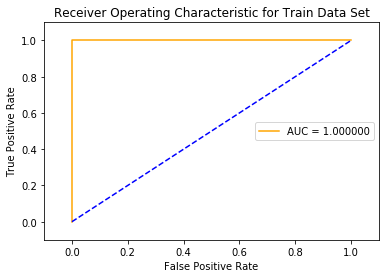

The train set error rate for Random Forest with class balancing is:  0.0


In [111]:
rfc_balanced = RandomForestClassifier(n_estimators=100, random_state=0, oob_score=True, class_weight='balanced')  
rfc_balanced.fit(x_train, y_train) 
y_train_balance_pred = rfc_balanced.predict(x_train)
y_test_balance_pred = rfc_balanced.predict(x_test)

# Train Data
# Confusion Matrix
print('The confusion matrix for the train data is: ')         
print(confusion_matrix(y_train, y_train_balance_pred))

#Roc curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_balance_pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='orange', label='AUC = %f' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue',  linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('Receiver Operating Characteristic for Train Data Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="right")
plt.show()

#train error
train_error = 1 - rfc_balanced.score(x_train, y_train)
print('The train set error rate for Random Forest with class balancing is:', train_error)

The confusion matrix for the test data is: 
[[15610    15]
 [  170   205]]


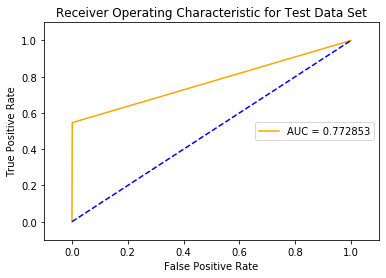

The Out of Bag error for Random Forest is: 0.007900000000000018
The test set error rate for Random Forest with class balancing is:  0.011562500000000031


In [112]:
# Test Data
# Confusion Matrix
print('The confusion matrix for the test data is: ')         
print(confusion_matrix(y_test, y_test_balance_pred))

#Roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_balance_pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='orange', label='AUC = %f' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue',  linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('Receiver Operating Characteristic for Test Data Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="right")
plt.show()

#test error
oob_error = 1 - rfc_balanced.oob_score_
test_error = 1 - rfc_balanced.score(x_test, y_test)
print('The Out of Bag error for Random Forest is:', oob_error)
print('The test set error rate for Random Forest with class balancing is: ', test_error)

**The unbalanced and balanced case both perform the same on the training set with an error rate of 0.0. The error rate on both the test set and Out of Bag error for the unbalanced case were slightly better than the balanced case. The error rate on the test set was 0.0079 for unbalanced case and 0.01156 for the balanced case, while the Out of Bag error rate was 0.006 for uncompensated case and 0.0079 for the balanced case.**

### (e) Model Trees

### (f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance. Train a Logistic Model Tree using the pre-processed data and repeat 2e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE.

In [115]:
smote = SMOTE(random_state = 5, sampling_strategy = 0.5)

### 3. ISLR, 6.8.3 <br>Suppose we estimate the regression coefficients in a linear regression model by minimizing $$\sum_{i=1}^n(y_i-β_0-\sum_{j=1}^pβ_j x_{ij}) \;subject \;to \sum_{j=1}^p|β_j|≤s $$ of i. through v is correct. Justify your answer.

#### (a) As we increase s from 0, the training RSS will:
*iv. Steadily decrease <br>
As s increases, we are lowering the restrictions of $β_j$ less and less. This results in a decreasing training RSS as the model fits the training data more and more.*

#### (b) Repeat (a) for test RSS. 
*ii. Decrease initially, and then eventually start increasing in a U shape.  <br>
As s increases, we are lowering the restrictions of $β_j$ less and less. This means we make the model more and more flexible to fit the training data. However, in a real world situation (testing data) if we fit the model too well towards the training data, this will result in overfitting.*

#### (c) Repeat (a) for variance
*iii. Steadily increase. <br>
As s increases, we are lowering the restrictions of $β_j$ less and less. A steadily increasing model flexibility results in a growth in variance (variance/bias tradeoff).*

#### (d) Repeat (a) for (squared) bias.
*iv. Steadily decrease <br>
As s increases, we are lowering the restrictions of $β_j$ less and less. A steadily increasing model flexibility results in a decrease in bias (variance/bias tradeoff).*

#### (e) Repeat (a) for the irreducible error. 
*v. Remain constant <br>
The irreducible error is independent of the model.*

### 4. ISLR, 6.8.5 <br>It is well-known that ridge regression tends to give similar coefficient values to correlated variables, whereas the lasso may give quite different coefficient values to correlated variables. We will now explore this property in a very simple setting.  <br>Suppose that $n = 2$, $p = 2$, $x_{11} = x_{12}$, $x_{21} = x_{22}$. Furthermore, suppose that $y_1+y_2 =0$ and $x_{11}+x_{21} =0$ and $x_{12}+x_{22} =0$, so that the estimate for the intercept in a least squares, ridge regression, or lasso model is zero: $βˆ0 = 0$. 

#### (a) Write out the ridge regression optimization problem in this setting. 
*We seek to minimize the ridge regression function.<br>
The function is $(y_1-β_1 x_1-β_2 x_1)^2+ (y_2-β_2 x_1-β_2 x_2)^2+ λ(β_1^2+β_2^2)$*

#### (b) Argue that in this setting, the ridge coefficient estimates satisfy $β_1 = β_2$. 
*If we differentiate the regression function in (a) with $β_1$ and $β_2$ and equate it to 0, we can subtract the two expressions and achieve $β_1 = β_2$.*

#### (c) Write out the lasso optimization problem in this setting.
*We seek to minimize the lasso regression function. <br>
The function is $(y_1-β_1 x_1-β_2 x_1)^2+ (y_2-β_2 x_1-β_2 x_2)^2+λ(|β_2|+|β_2|)$*

#### (d) Argue that in this setting, the lasso coefficients $βˆ1$ and $βˆ2$ are not unique—in other words, there are many possible solutions to the optimization problem in (c). Describe these solutions. 
*The lasso function takes a diamond shape with a distance s from the origin. If we use the information of $x_{11}=x_{12}= x_1$, $x_{21}=x_{22}=x_2$, $x_1+x_2=0$, $y_1+y_2=0$, and minimize the function above. By using the expression computed and lining it up with the diamond shape the lasso function takes, we have a whole set of potential solutions on the edge of the diamond. {$(β_1,β_2 ) β_1+β_2=s \;\; with \;\; 0≤β_1,β_2  \; and  \; -s=β_1,β_2   \;\;with  \;\; β_1,β_2≤0$}*

### 5. ISLR, 8.4.5 <br>Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X, produce 10 estimates of P(Class is Red|X):  0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, and 0.75.<br>There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?

*If we’re using the majority vote approach, we classify XX as Red as it is the most commonly occurring class among the 10 predictions (6 for Red vs 4 for Green). With the average probability approach, we would classify XX as Green as the average of the 10 probabilities is 0.45.*

### 6. ISLR, 9.7.3 Here we explore the maximal margin classifier on a toy data set. 

#### (a)	We are given n = 7 observations in p = 2 dimensions. For each observation, there is an associated class label. 
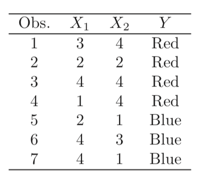
Sketch the observations. 

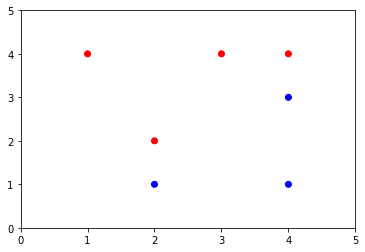

In [129]:
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
colors = ["red", "red", "red", "red", "blue", "blue", "blue"]
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.scatter(x1, x2, color = colors)

#### (b)  Sketch the optimal separating hyperplane, and provide the equation for this hyperplane (of the form (9.1)). 

*The optimal separating hyperplane has to be between the observations {(2,1) and (2,2)}, and {(4,3) and (4,4)}. So it is a line that passes through the points (2,1.5) and (4,3.5). The equation we arrive at is $ X_1 - X_2 -0.5 = 0$*

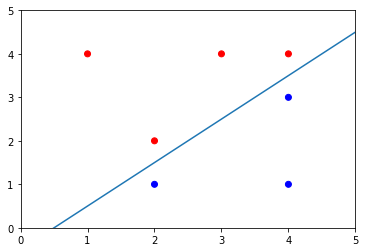

In [132]:
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.scatter(x1, x2, color = colors)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = -0.5 + 1 * x_vals
plt.plot(x_vals, y_vals, '-')

#### (c)  Describe the classification rule for the maximal margin classifier. It should be something along the lines of “Classify to Red if $β_0 + β_1X_1 + β_2X_2 > 0$, and classify to Blue otherwise.” Provide the values for $β_0$, $β_1$, and $β_2$.

*We classify to red if $ X_1 - X_2 -0.5 < 0$ and blue if otherwise. ($β_0=-0.5$, $β_1=1$, $β_1=-1$)*

#### (d)  On your sketch, indicate the margin for the maximal margin hyperplane. 

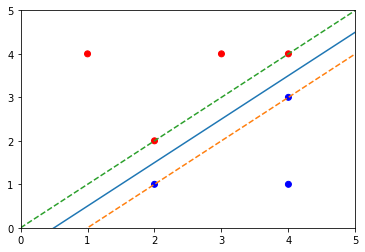

In [133]:
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.scatter(x1, x2, color = colors)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = -0.5 + 1 * x_vals
plt.plot(x_vals, y_vals, '-')
left_y_vals = -1 + 1 * x_vals
right_y_vals = -0 + 1 * x_vals
plt.plot(x_vals, left_y_vals, '--')
plt.plot(x_vals, right_y_vals, '--')

#### (e)  Indicate the support vectors for the maximal margin classifier. 

*The support vectors are {(2,1) and (2,2)}, {(4,3) and (4,4)}.*

#### (f)  Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane. 

*When we look at the plot, it's clear that a slight movement of (4,1) wouldn't effect the hyperplane since it's not a support vector.*

#### (g) Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.

$$ X_1 - X_2 -0.2 = 0$$

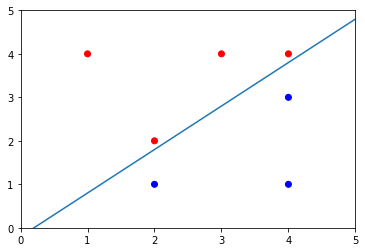

In [134]:
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.scatter(x1, x2, color = colors)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = -0.2 + 1 * x_vals
plt.plot(x_vals, y_vals, '-')

#### (h)  Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.

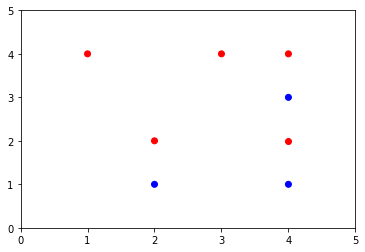

In [137]:
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.scatter(x1, x2, color = colors)
plt.scatter(4,2, color = "red")

*With the addition of (4,2), a hyperplane cannot separate the two classes anymore.*